# Import Libararies

In [ ]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from prettytable import PrettyTable
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from keras.callbacks import EarlyStopping

# Check GPU detected

In [ ]:
print(tf.__version__) # Check Enviroment Variable CUDA_VISIBLE_DEVICES
print(tf.config.list_physical_devices()) # Check in the terminal using nvidia-smi to monitor usage

# Convert the dataset into numpy arrays, or retrieve pickled objects

In [ ]:
train=r"D:\finalconvcough"
category=["healthypng","covidpng"]
data=[]
Model="SPEC"
for i in category:
    path=os.path.join(train,i)
    label=category.index(i)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        img_arr=cv2.imread(img_path,0)
        data.append([img_arr,label])
random.shuffle(data)
x=[]
y=[]
x_test=[]
y_test=[]
for features,labels in data:
    x.append(features)
    y.append(labels)
    
x_test=np.array(x[int(len(x)*0.85):-1])
y_test=np.array(y[int(len(y)*0.85):-1])

x=np.array(x[0:int(0.85*len(x))])
y=np.array(y[0:int(0.85*len(y))])

x=x/255
x_test=x_test/255

data.clear()

x=x.reshape(len(x),256,256,1)
x_test=x_test.reshape(len(x_test),256,256,1)

# Increase Page file size if Memory_Error occurs

In [ ]:
pickle.dump(x,open('x_spec.pkl','wb'))
pickle.dump(y,open('y_spec.pkl','wb'))
pickle.dump(x_test,open('x_spec_test.pkl','wb'))
pickle.dump(y_test,open('y_spec_test.pkl','wb'))

In [ ]:
x=pickle.load(open('x_spec.pkl','rb'))
x_test=pickle.load(open('x_spec_test.pkl','rb'))
y=pickle.load(open('y_spec.pkl','rb'))
y_test=pickle.load(open('y_spec_test.pkl','rb'))

# Build the CNet

In [ ]:
def Train():
    # To prevent Resources_Exausted_Error
    gpu_options=tf.compat.v1.GPUOptions(allow_growth=True)
    config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)
    config.gpu_options.per_process_gpu_memory_fraction = 0.99
    session = tf.compat.v1.InteractiveSession(config=config)

    model=tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=x.shape[1:],activation="relu",padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))


    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64,activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())

    
    model.add(tf.keras.layers.Dense(32,activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())


    model.add(tf.keras.layers.Dense(2,activation="softmax"))


    model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['acc']) # or binary_crossentropy

    es=EarlyStopping(monitor='val_loss')
    
    model.fit(x,y,epochs=4,validation_split=0.1)
    try:
        session.close()
    except:
        print('meh')

    return model

In [ ]:
model=Train()

loss,win=model.evaluate(x_test,y_test)
print('============================================================================================\n')
print('loss: {}, acc: {}'.format(loss,win))

model.summary()

Epoch 1/4
170/170 [==============================] - 227s 1s/step - loss: 0.4294 - acc: 0.8546 - val_loss: 0.3760 - val_acc: 0.8947
Epoch 2/4
170/170 [==============================] - 226s 1s/step - loss: 0.2530 - acc: 0.9283 - val_loss: 0.6545 - val_acc: 0.4737
Epoch 3/4
170/170 [==============================] - 231s 1s/step - loss: 0.2532 - acc: 0.9270 - val_loss: 0.5451 - val_acc: 0.8816
Epoch 4/4
5/5 [==============================] - 5s 842ms/step - loss: 0.1696 - acc: 0.9470

loss: 0.169569730758667, acc: 0.9469696879386902
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 610, 450, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 305, 225, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4392000)

# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(x, y)

y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# Saving the model after achieving 95% accuracy

In [ ]:
model.save("SPEC_V1")

INFO:tensorflow:Assets written to: SPEC_V1\assets


In [ ]:
model=tf.keras.models.load_model("SPEC_V1")

# Strandradized Table for the model acuuaracy and after 30 runs.

In [ ]:
for i in range(30):
    model=Train()
    test=model.evaluate(x_test,y_test)
    with open(r'avg.txt','a+') as file:
        file.write("{},{}\n".format(test[1],test[0]))

# Confusion Matrix 

True


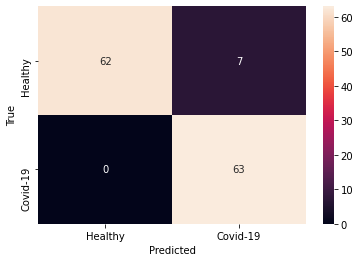

In [ ]:
singlepredict=[]
singletest=[]
predict=model.predict([x_test]) # not the best way to get a some neat labels
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())# If false then confusion.numpy will produce error

singlepredict=np.argmax(predict,1) # I forget what it does exactly or how it does it
singletest=np.array(y_test)
confusion=tf.math.confusion_matrix(labels=singletest, predictions=singlepredict).numpy()
#plt.imshow(confusion) # Green Confusion Matrix
sns.heatmap(confusion , annot=True , xticklabels=['Healthy' , 'Covid-19'] , yticklabels=['Healthy' , 'Covid-19'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Metrics

In [ ]:
precision, recall, f1, _ = score(singletest, singlepredict)
print('Precision: {},Averge: {}'.format(precision,sum(precision)/len(precision)))
print('Recall: {},Average: {}'.format(recall,sum(recall)/len(recall)))
print('F-score: {},Average: {}'.format(f1,sum(f1)/len(f1)))


Precision: [1.  0.9],Averge: 0.95
Recall: [0.89855072 1.        ],Average: 0.9492753623188406
F-score: [0.94656489 0.94736842],Average: 0.9469666532744074


In [ ]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
val_loss = model.history.history['val_loss']
loss = model.history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, [i*100 for i in acc], 'green', label='Training acc')
plt.plot(epochs,[i*100 for i in val_acc], 'blue', label='Validation acc')

plt.plot(epochs, [i*100 for i in loss], 'red', label='Training loss')
plt.plot(epochs,[i*100 for i in val_loss], 'black', label='Validation loss')
plt.title('Training, validation accuaracy and loss over epochs')#'Training and validation loss'
plt.legend()

plt.show()

# Some visulization into some cases in the dataset, the prediction and the true output.

In [ ]:
predict=model.predict([x_test])

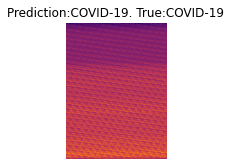

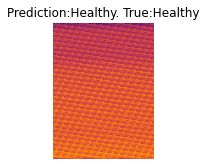

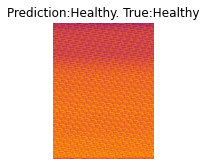

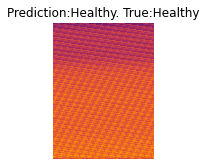

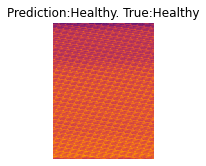

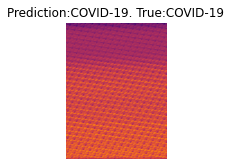

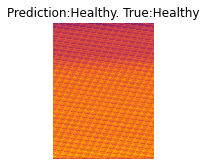

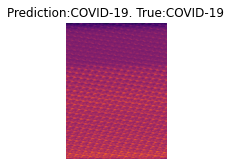

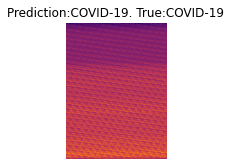

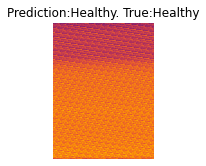

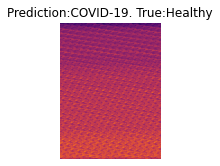

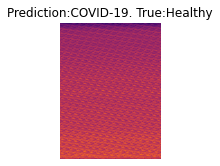

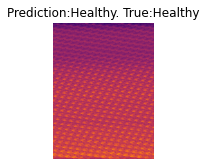

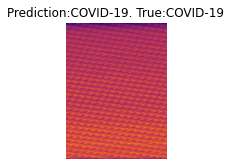

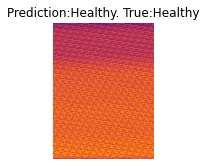

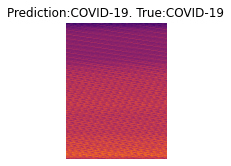

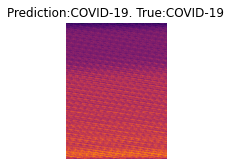

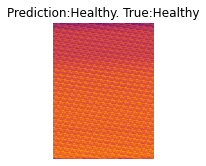

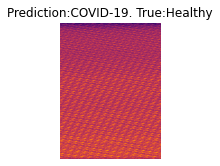

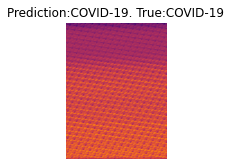

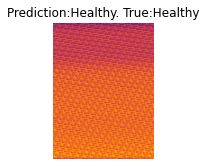

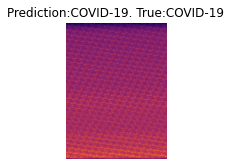

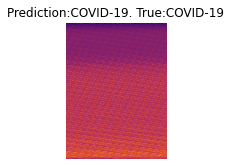

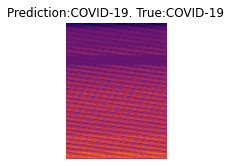

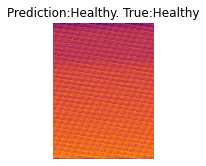

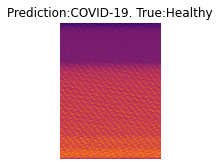

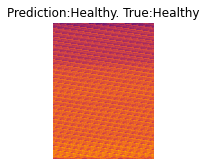

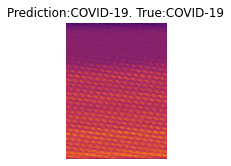

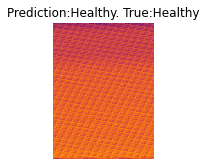

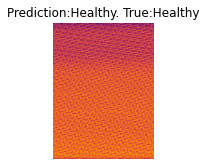

In [ ]:
def simpleargmax(n):
    if list(n).index(max(n))==0:
        return "Healthy"
    elif list(n).index(max(n))==1:
        return "COVID-19"
def label(m):
    if m==0:
        return "Healthy"
    elif m==1:
        return "COVID-19"
for i in range(30):
    plt.figure(figsize = (2.5,2.5))
    val=random.randint(0,len(x_test)-1)
    plt.axis("off")
    plt.imshow(x_test[val], cmap='inferno')
    plt.title("Prediction:{}. True:{}".format(simpleargmax(predict[val]),label(y_test[val])))
    plt.show()